In [1]:
import torch
import triton
import triton.language as tl

import torch
import time
import numpy as np
import matplotlib.pyplot as plt

In [20]:
@triton.jit
def gptq_kernel(
    a_ptr, # Input Activation function (Non quantized) Shape - [M, K]
    b_ptr, # Quantized weights - [K//8, N] since each int32 can pack in 8 4bit weights
    c_ptr, # Output matrix
    scales_ptr,
    zeros_ptr, # These two are needed for dequantization
    M, N, K, # matrix dimensions
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Quantization parameters
    stride_zeros_g, stride_zeros_n,
    stride_scales_g, stride_scales_n,
    groupsize, # Size of each quantization group
    # Kernel parameters
    BLOCK_SIZE_M : tl.constexpr,
    BLOCK_SIZE_N : tl.constexpr,
    BLOCK_SIZE_K : tl.constexpr,
    GROUP_SIZE_M : tl.constexpr):
    """
    - Full precision B - [K,N] 4 bit --> [K//8, N]
    - We store one scale per group, therefore scales = [K//GROUP_SIZE, N]
    - Zeroes - [K//GROUP_SIZE, N//8]
    """
    pid = tl.program_id(0)

    # total blocks in each dimension
    num_blocks_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_blocks_n = tl.cdiv(N, BLOCK_SIZE_N)

    # We use grouped ordering to improve cache locality
    num_blocks_in_group = GROUP_SIZE_M * num_blocks_n
    group_id = pid // num_blocks_in_group
    group_size = min(GROUP_SIZE_M, num_blocks_m - group_id * GROUP_SIZE_M) # This is to account for the last group which may have less than GROUP_SIZE_M elements

    # Calculating which output block this program is responsible for
    pid_m = group_id * GROUP_SIZE_M + (pid % group_size)
    pid_n = (pid % num_blocks_in_group) // group_size

    # Starting indices for this block
    offsets_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offsets_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)

    # Handling boundaries
    offset_m = tl.multiple_of(offsets_m, BLOCK_SIZE_M)
    offset_n = tl.multiple_of(offsets_n, BLOCK_SIZE_N)

    offsets_k = tl.arange(0, BLOCK_SIZE_K)

    # Pointers for A, B, scales and zeroes
    a_ptrs = a_ptr + offset_m[:, None] * stride_am + offsets_k[None, :] * stride_ak

    b_ptrs =  b_ptr + (offsets_k[:, None] // 8) * stride_bk + offset_n[None, :] * stride_bn # We need to account for the 4-bit quantization

    scales_ptr = scales_ptr + offsets_n * stride_scales_n # Scaling happens per output feature N

    zeros_ptrs = zeros_ptr + ((offsets_n // 8) * stride_zeros_n) # zeros is indexed by N // 8 because each int32 stores 8 zero-points

    # Computing bit shift amounts for unpacking 4-bit values
    # Finding the correct 4-bit weight
    shifter = (offsets_k % 8)* 4 # each 4 bit value shifted by a multiple of 4

    zeros_shifter = (offsets_n % 8) * 4 # each 4 bit value shifted by a multiple of 4

    output = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_N], dtype = tl.float32)

    # Iterate over the k blocks
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs)

        b = tl.load(b_ptrs)

        # Checking which group id this K block belongs to
        # Each group shares the scaling factor and zero point
        g_id = k // (groupsize // BLOCK_SIZE_K)

        # Loading the scale value for this group
        group_scales_ptrs = scales_ptr + g_id * stride_scales_g

        scales = tl.load(group_scales_ptrs)

        # Loading the zero value for this group
        group_zeros_ptrs = zeros_ptrs + g_id * stride_zeros_g

        zeros = tl.load(group_zeros_ptrs)

        # Extracting the correct zero pointer from the packed int 32
        zeros = (zeros >> zeros_shifter) & 0xF

        # Applying the scale to the zero points
        zeros =  (zeros + 1) * scales

        # Extracting the correct 4 bit value from b
        b = (b >> shifter[:, None]) & 0xF

        # Dequantize weights using scales and zero points
        b = b * scales[None, :] - zeros[None, :]

        output += tl.dot(a, b)

        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += (BLOCK_SIZE_K // 8) * stride_bk

    output = output.to(tl.float16)

    # Writing the output block to C
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + (offs_cm[:, None] * stride_cm + offs_cn[None, :] * stride_cn)

    # Only store the output if it's within the bounds of the matrix
    mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, output, mask=mask)


In [21]:
class GPTQLinear(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, b, scales, zeros, groupsize = 128):
        M, K = a.shape
        _, N = b.shape

        BLOCK_SIZE_M = 16
        BLOCK_SIZE_N = 32
        BLOCK_SIZE_K = 64
        GROUP_SIZE_M = 8

        total_blocks_m = triton.cdiv(M, BLOCK_SIZE_M)
        total_blocks_n = triton.cdiv(N, BLOCK_SIZE_N)
        total_programs = total_blocks_m * total_blocks_n
        grid = (total_programs, 1)

        c = torch.empty((M, N), dtype = a.dtype , device = a.device)

        gptq_kernel[grid](
            a, b, c,
            scales, zeros,
            M, N, K,
            a.stride(0), a.stride(1),
            b.stride(0), b.stride(1),
            c.stride(0), c.stride(1),
            scales.stride(0), scales.stride(1),
            zeros.stride(0), zeros.stride(1),
            groupsize,
            BLOCK_SIZE_M = BLOCK_SIZE_M,
            BLOCK_SIZE_N = BLOCK_SIZE_N,
            BLOCK_SIZE_K = BLOCK_SIZE_K,
            GROUP_SIZE_M = GROUP_SIZE_M
        )

        return c

def gptq_linear(a, b, scales, zeros, groupsize = 128):
    return GPTQLinear.apply(a, b, scales, zeros, groupsize)

In [22]:
M, N, K, groupsize = 1024, 1024, 4096, 128
device = torch.device("cuda")

In [23]:
def create_test_data(M, K, N, groupsize=128, device="cuda"):
    """Create test data for GPTQ kernel"""
    a = torch.randn(M, K, dtype=torch.float16, device=device)

    # Create quantized weight matrix (int32)
    b = torch.randint(-8, 7, (K // 8, N), dtype=torch.int32, device=device)

    # Create scaling factors (float16)
    scales = torch.rand(K // groupsize, N, dtype=torch.float16, device=device)

    # Create zero points (int32)
    # Each int32 value packs 8 4-bit zero points
    zeros = torch.randint(0, 15, (K // groupsize, N // 8), dtype=torch.int32, device=device)

    return a, b, scales, zeros

In [24]:
def reference_gptq_matmul(a, b, scales, zeros, groupsize=128):
    """Reference implementation of GPTQ matrix multiplication (slow but correct)"""
    M, K = a.shape
    _, N = b.shape

    # Initialize output
    c = torch.zeros((M, N), dtype=torch.float16, device=a.device)

    # Iterate over each group
    for g in range(K // groupsize):
        # For each element in the group
        for k_in_g in range(groupsize):
            k = g * groupsize + k_in_g

            # Get the scaling factors for this group
            scale = scales[g]

            # Get the zero points for this group
            zero_packed = zeros[g]
            zero_unpacked = torch.zeros(N, dtype=torch.float16, device=a.device)

            # Unpack zero points
            for i in range(N // 8):
                for j in range(8):
                    idx = i * 8 + j
                    if idx < N:
                        zero_unpacked[idx] = ((zero_packed[i] >> (j * 4)) & 0xF) + 1

            # Apply scale to zero points
            zero_unpacked = zero_unpacked * scale

            # Unpack weights for this row
            w_packed = b[k // 8]
            w_unpacked = torch.zeros(N, dtype=torch.float16, device=a.device)

            # Extract weights
            for i in range(N):
                shift = (k % 8) * 4
                w_unpacked[i] = ((w_packed[i] >> shift) & 0xF)

            # Dequantize weights
            w_dequant = w_unpacked * scale - zero_unpacked

            # Update output
            for m in range(M):
                c[m] += a[m, k] * w_dequant

    return c

In [25]:
def benchmark_and_verify(sizes):
    """Benchmark and verify the GPTQ kernel implementation against reference"""
    results = []

    for M, K, N in sizes:
        # Skip if dimensions don't align with our requirements
        if K % 8 != 0 or K % 128 != 0 or N % 8 != 0:
            continue

        # Create test data
        a, b, scales, zeros = create_test_data(M, K, N)

        # Run kernel
        torch.cuda.synchronize()
        start = time.time()
        c_kernel = gptq_linear(a, b, scales, zeros)
        torch.cuda.synchronize()
        kernel_time = time.time() - start

        # Run reference (only for small sizes to avoid excessive runtime)
        if M * K * N <= 1024 * 1024:  # Limit to matrices of ~1M elements
            start = time.time()
            c_ref = reference_gptq_matmul(a, b, scales, zeros)
            ref_time = time.time() - start

            # Check accuracy
            max_diff = torch.max(torch.abs(c_kernel - c_ref)).item()
            mean_diff = torch.mean(torch.abs(c_kernel - c_ref)).item()
        else:
            ref_time = float('inf')
            max_diff = 0
            mean_diff = 0

        # Calculate TFLOPs (approximate)
        # Each matrix-multiply element requires 2*K operations
        flops = 2 * M * N * K
        tflops = flops / (kernel_time * 1e12)

        results.append({
            'M': M,
            'K': K,
            'N': N,
            'kernel_time_ms': kernel_time * 1000,
            'reference_time_ms': ref_time * 1000,
            'max_diff': max_diff,
            'mean_diff': mean_diff,
            'speedup': ref_time / kernel_time if ref_time != float('inf') else float('inf'),
            'tflops': tflops
        })

        print(f"M={M}, K={K}, N={N}: Kernel: {kernel_time*1000:.2f}ms, "
              f"TFLOPs: {tflops:.2f}, Max diff: {max_diff:.6f}")

    return results

In [26]:
def plot_results(results):
    """Plot benchmark results"""
    # Extract dimensions and performance data
    sizes = [f"{r['M']}x{r['K']}x{r['N']}" for r in results]
    kernel_times = [r['kernel_time_ms'] for r in results]
    tflops = [r['tflops'] for r in results]

    # Create the figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot bars for kernel time
    x = np.arange(len(sizes))
    width = 0.35
    ax1.bar(x - width/2, kernel_times, width, label='Kernel Time (ms)', color='b', alpha=0.6)
    ax1.set_ylabel('Execution Time (ms)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create second y-axis for TFLOPs
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, tflops, width, label='TFLOPs', color='r', alpha=0.6)
    ax2.set_ylabel('TFLOPs', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Set x-axis ticks and labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(sizes, rotation=45)

    # Add a title and legend
    plt.title('GPTQ Kernel Performance')
    fig.tight_layout()

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Save and show the plot
    plt.savefig('gptq_performance.png')
    plt.show()

In [27]:
def main():
    # Test with various matrix sizes
    sizes = [
        (1, 1024, 1024),      # Single vector, typical embedding size
        (16, 1024, 1024),     # Small batch
        (32, 1024, 4096),     # Medium batch, larger output
        (64, 4096, 4096),     # Larger batch, larger dims
        (128, 4096, 11008),   # Typical LLaMA layer size
        (256, 4096, 4096),    # Large batch
    ]

    # Run benchmarks
    results = benchmark_and_verify(sizes)

    # Plot results
    plot_results(results)

M=1, K=1024, N=1024: Kernel: 612.70ms, TFLOPs: 0.00, Max diff: 416.750000
M=16, K=1024, N=1024: Kernel: 500.19ms, TFLOPs: 0.00, Max diff: 0.000000
M=32, K=1024, N=4096: Kernel: 0.30ms, TFLOPs: 0.90, Max diff: 0.000000
M=64, K=4096, N=4096: Kernel: 0.37ms, TFLOPs: 5.88, Max diff: 0.000000
M=128, K=4096, N=11008: Kernel: 1.11ms, TFLOPs: 10.37, Max diff: 0.000000
M=256, K=4096, N=4096: Kernel: 0.85ms, TFLOPs: 10.16, Max diff: 0.000000


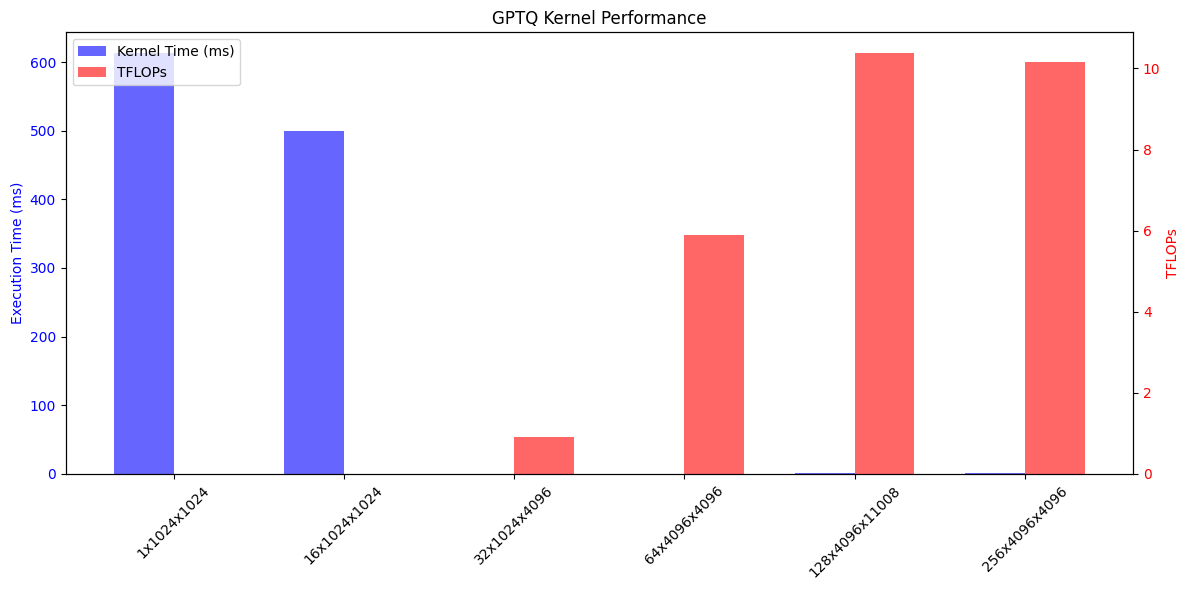

In [28]:
main()